In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gibbs_sampling import *
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

c:\Users\bapti\OneDrive\Bureau\GitHub\bayesian_statistics_project\gibbs_sampling.py:18: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def density_R2(r, z):


In [2]:
# Open macro1 dataset
df = pd.read_csv('Data/macro1.csv')
df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,Transform:,5.0,5.0,5.000,5.000000,5.00000,5.0000,5.0000,5.0000,5.0000,...,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0,6.0,1.0
1,01/01/1959,2289.8,2151.9,18.191,253747.578885,18234.44037,21.9289,21.5499,20.9407,28.4830,...,12.133,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2,NaN
2,02/01/1959,2299.6,2160.2,18.380,255653.461901,18368.21974,22.3584,21.8408,21.1221,28.6919,...,12.149,2.13,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5,NaN
3,03/01/1959,2314.4,2176.1,18.555,254743.765035,18521.70306,22.6805,21.9730,21.2257,28.6919,...,12.169,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6,NaN
4,04/01/1959,2328.5,2190.3,18.488,259878.438046,18533.11060,23.1636,22.2903,21.5367,29.1445,...,12.211,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8,NaN


In [3]:
# We remove the first row
df = df.iloc[1:]
df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
1,01/01/1959,2289.8,2151.9,18.191,253747.578885,18234.44037,21.9289,21.5499,20.9407,28.4830,...,12.133,2.13,2.45,2.04,NaN,274.9,6476.0,12298.0,84.2,NaN
2,02/01/1959,2299.6,2160.2,18.380,255653.461901,18368.21974,22.3584,21.8408,21.1221,28.6919,...,12.149,2.13,2.46,2.05,NaN,276.0,6476.0,12298.0,83.5,NaN
3,03/01/1959,2314.4,2176.1,18.555,254743.765035,18521.70306,22.6805,21.9730,21.2257,28.6919,...,12.169,2.15,2.45,2.07,NaN,277.4,6508.0,12349.0,81.6,NaN
4,04/01/1959,2328.5,2190.3,18.488,259878.438046,18533.11060,23.1636,22.2903,21.5367,29.1445,...,12.211,2.16,2.47,2.08,NaN,278.1,6620.0,12484.0,81.8,NaN
5,05/01/1959,2342.5,2205.6,18.710,261691.222172,18678.29753,23.5125,22.4754,21.7441,29.2838,...,12.230,2.17,2.48,2.08,95.3,280.1,6753.0,12646.0,80.7,NaN


In [4]:
# We remove the features in which there are a lot of Nan values
pd.DataFrame(df.isna().sum()).sort_values(0, ascending=False).iloc[:10]

,0
ACOGNO,398
TWEXMMTH,168
UMCSENTx,154
ANDENOx,109
VXOCLSx,42
PERMITW,12
PERMITS,12
PERMITMW,12
PERMITNE,12
PERMIT,12


In [5]:
columns_to_drop = ['ACOGNO', 'TWEXMMTH', 'UMCSENTx', 'ANDENOx', 'VXOCLSx']
df = df.drop(columns_to_drop,axis=1)

# We remove the remaining NaN values
df = df.dropna()

# We reorder the columns
columns = df.columns.tolist()
new_column_order = ['INDPRO'] + [column for column in columns if column not in ['sasdate', 'INDPRO']]
df = df[new_column_order]

df.head()

,INDPRO,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
13,24.1298,2391.2,2252.3,18.910,263212.787497,18762.29853,23.3215,22.6512,30.5722,20.1768,...,54.611,20.000,12.502,2.22,2.57,2.13,286.7,7362.0,14063.0,75.5
14,23.9151,2392.8,2253.8,18.993,267039.890455,18831.78084,23.1893,22.5734,30.2240,19.8991,...,54.700,20.001,12.522,2.23,2.59,2.14,287.0,7396.0,14144.0,73.3
15,23.7004,2397.2,2255.4,19.262,259610.179810,18811.03986,23.1100,22.5475,30.2588,19.5057,...,54.540,20.037,12.529,2.24,2.69,2.14,287.8,7456.0,14239.0,71.5
16,23.5125,2405.6,2263.4,19.560,262179.545533,19304.67539,23.1629,22.5734,30.4677,19.4826,...,54.606,20.163,12.555,2.24,2.61,2.14,288.3,7582.0,14413.0,71.5
17,23.4857,2411.7,2269.4,19.166,254056.886617,19016.37565,23.2951,22.7289,30.6418,19.6677,...,54.600,20.154,12.590,2.24,2.64,2.14,289.1,7673.0,14559.0,71.7


In [6]:
num_predictors = len(df.columns) - 1
num_predictors

120

In [7]:
# We initialize the parameters for the Gibbs
a, b, A, B = 1, 1, 1, 1 # Parameters for Beta laws
q = np.random.beta(a, b, 1)[0]
R_2 = np.random.beta(A, B, 1)[0]

start = np.arange(0, 0.1 + 0.001, 0.001)[1:]
mid = np.arange(0.11, 0.9 + 0.01, 0.01)
end = np.arange(0.901, 1 + 0.001, 0.001)[:-1]
support = np.concatenate((start, mid, end))

In [8]:
# We define the outcome y and the predictors X
X = df.drop(['INDPRO'], axis=1)
y = df['INDPRO']

C:\Users\bapti\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e+01, tolerance: 2.971e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\bapti\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.231e+01, tolerance: 2.971e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\bapti\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

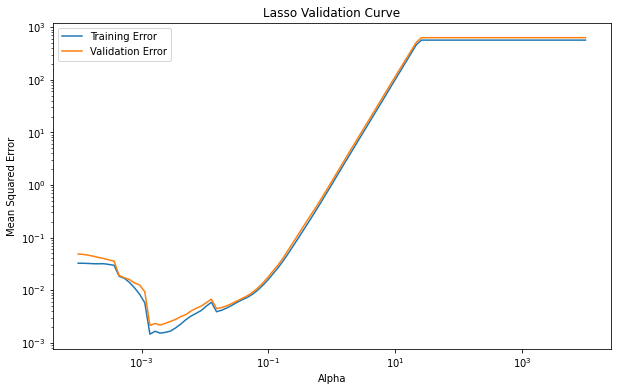

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)
alphas = np.logspace(-4, 4, 100)
train_errors = []
validation_errors = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha,max_iter=10000)
    lasso_model.fit(X_train_scaled, y_train)  # Supposons que X_train et y_train soient vos données d'entraînement
    y_pred_train = lasso_model.predict(X_train_scaled)
    y_pred_validation = lasso_model.predict(X_test_scaled)  # Supposons que X_validation soit votre ensemble de validation
    
    train_errors.append(mean_squared_error(y_train, y_pred_train))  # Vous pouvez utiliser une autre métrique de performance
    validation_errors.append(mean_squared_error(y_test, y_pred_validation))

# Tracer la courbe de validation
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_errors, label='Training Error')
plt.plot(alphas, validation_errors, label='Validation Error')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')  # Utilisez la métrique de performance appropriée
plt.legend()
plt.title('Lasso Validation Curve')
plt.show()

#$\alpha _{opt}$ = 0.005 : (Train Error , Validation Error) = (0.33548518219396917, 0.32653694179816917)

In [10]:
# Now, we run the Lasso Regression using our best regularization term.
lasso_model = Lasso(alpha=0.005)
lasso_model.fit(X_train_scaled, y_train)
beta_estimates = lasso_model.coef_

C:\Users\bapti\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+02, tolerance: 2.971e+01
  model = cd_fast.enet_coordinate_descent(


In [11]:
y_pred_train = lasso_model.predict(X_train_scaled)
y_pred_validation = lasso_model.predict(X_test_scaled)  # Supposons que X_validation soit votre ensemble de validation
train_error = mean_squared_error(y_train, y_pred_train)
validation_error = mean_squared_error(y_test, y_pred_validation)

# We can get the train and validation errors
train_error , validation_error

(0.12371893270533105, 0.13578030507949632)

In [12]:
# We get z_initial to initialise the gibbs with the beta that we found
z_initial = (np.abs(beta_estimates) > 0).astype(int)
z_initial.sum()

50

In [13]:
import random as random

my_array = np.array([1]*1+[0]*119)
random.shuffle(my_array)
my_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
np.linalg.norm(beta_estimates,ord=1)

47.05484454289537

In [14]:
# z_final = sample_z(Y=y, X=X_scaled, q_start=q, R_2_start=R_2, num_iterations=1000, z=z_initial, support=support)
# pd.DataFrame(z_final).to_csv('Data/z_sample.csv')

# As the computation time is long, we saved our previous run and use it for the rest of the program
z_final = pd.read_csv('Data/z_sample.csv', index_col='Unnamed: 0')
z_final = z_final['0'].to_numpy()

z_final

array([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1], dtype=int64)

In [15]:
# We only keep the columns for which z_final is equal to 1
X_tilde = X_scaled[:, z_final == 1]

X_train, X_test, y_train, y_test = train_test_split(X_tilde, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.0006468239371911561
R-squared: 0.9999989738856792


In [16]:
# Get the beta coefficients.
coefficients_beta = model.coef_

# Display the coefficients as an array.
print("Coefficients beta:", coefficients_beta)

Coefficients beta: [-5.05947376e-02 -2.71926108e-01  2.38198122e-01  1.35831526e+01
 -6.19328987e-01  2.30805071e-01  2.63603408e-02  2.04165950e-01
  1.09162399e+01 -2.75112920e-02  2.47194923e-01  3.17191506e-02
 -2.33110118e-02 -3.97848632e-02 -7.30627666e-02  5.96839112e-03
 -3.48621259e+00  3.42557080e-02  2.36339799e-01  1.66295881e-01
  4.28964774e+00 -5.11024416e-01 -1.51096733e-01  2.22458678e-03
 -3.17076700e-02  6.19250157e-04  1.09528479e-02  4.43214892e-03
  4.94416390e-03  7.87308499e-03  2.07128514e-02 -2.94934183e-01
 -1.10726133e-02 -3.98288338e-01  1.91397420e-01  4.11882161e-02
  6.65392551e-02  1.37534671e-01 -6.89989968e-02 -4.78319008e-02
  8.33184893e-03 -5.18407646e-02  9.19609389e-02  2.24139331e-02
 -1.24262750e-02 -1.63656617e-02 -3.03886009e-02 -1.84095323e-02
 -4.69837443e-03 -1.40820661e-01  1.93834381e-03  4.92008199e+00
 -6.52666427e-02 -2.27779106e+00 -1.80905371e+00  4.77533658e-01
 -1.78107549e-01 -8.60559363e-01 -1.16380205e-01  8.70163581e-01
 -5.14

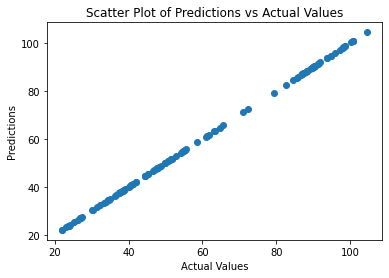

In [20]:
# Scatter Plot of Predictions vs Actual Values:
# Displays the predicted values by the model against the actual values.
# Helps visualize the model accuracy and identify trends.

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("Scatter Plot of Predictions vs Actual Values")
plt.show()

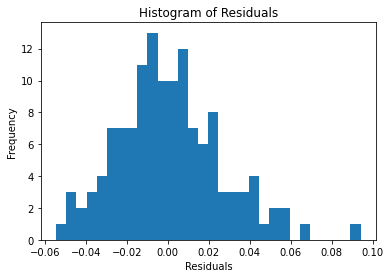

In [21]:
# Residual Histogram:
# Displays the distribution of residuals (differences between actual values and predictions).
# Useful for checking homoscedasticity (homogeneity of variance of residuals).

residuals = y_test - y_pred
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

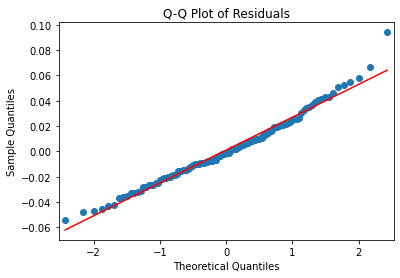

In [22]:
#Quantile-Quantile (Q-Q) Plot of Residuals:
#Compares the distribution of residuals with a theoretical normal distribution.
#Helps identify deviations from normality.

import statsmodels.api as sm

sm.qqplot(residuals, line='r')
plt.title("Q-Q Plot of Residuals")
plt.show()

## Initial problem :
We recall that our initial goal was to predict $\gamma_{t}$, with $\gamma_{t}$ defined as the observed industrial growth rate at time $t$. We made the assumption of the following model:
$ INDPRO = X^{T}\beta + \varepsilon $ with $ \varepsilon $ being Gaussian noise.
We also have the following formula: $ \gamma_{t} = \frac{ INDPRO_{t} - INDPRO_{t-1} }{ INDPRO_{t-1} } \times 100 $
Therefore, it is sufficient to predict $INDPRO$ to be able to predict $\gamma$, which gives us:
$ \hat\gamma_{t} = \frac{\hat{INDPRO}{t} - \hat{INDPRO}{t-1}}{\hat{INDPRO}_{t-1}} \times 100 $ with the predictions of $INDPRO$ obtained through linear regression.

In [23]:
# We will work on a copy
df_gamma = df.copy()

# We get the index of the test sample
Indpro_index = pd.DataFrame(y_test).index
# We then add the INDPRO_pred data into the working dataframe "df_gamma"
INDPRO_pred = pd.DataFrame(np.array([y_pred]).T , index = Indpro_index , columns = ['INDPRO_pred'])
df_gamma = df_gamma.loc[Indpro_index].rename(columns={'INDPRO' : 'INDPRO_test'})
df_gamma = pd.concat([df_gamma, INDPRO_pred], axis=1).sort_index().reset_index(drop=True)

df_gamma.head()

,INDPRO_test,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,INDPRO_pred
0,24.1298,2391.2,2252.3,18.910,263212.787497,18762.29853,23.3215,22.6512,30.5722,20.1768,...,20.000,12.502,2.22,2.57,2.13,286.7,7362.0,14063.0,75.5,24.161707
1,23.1904,2412.8,2268.2,19.161,256224.511174,18990.44941,23.0307,22.4697,30.4329,19.4595,...,20.150,12.614,2.24,2.64,2.14,290.2,7805.0,14816.0,71.2,23.223315
2,22.0631,2401.0,2247.3,19.064,252866.240591,18603.62997,22.2374,21.7700,29.6320,17.6547,...,20.373,12.757,2.27,2.71,2.16,299.9,7703.0,15435.0,78.3,22.028539
3,22.0900,2424.5,2269.0,19.112,243938.563937,18618.14866,22.2110,21.7182,29.3883,17.0068,...,20.368,12.754,2.27,2.72,2.16,301.3,7562.0,15317.0,79.4,22.073958
4,23.5930,2498.9,2325.9,19.537,252027.345616,18817.26215,23.2686,22.6512,31.2338,19.6908,...,20.253,12.870,2.32,2.77,2.21,310.9,7173.0,15168.0,81.9,23.540837


In [24]:
# We then calculate the gamma test and pred
df_gamma['gamma_test'] = ((df_gamma['INDPRO_test'].diff())/df_gamma['INDPRO_test'])*100
df_gamma['gamma_pred'] = ((df_gamma['INDPRO_pred'].diff())/df_gamma['INDPRO_pred'])*100

# We reorder the columns to get our columns of interest
columns_of_interess = ['INDPRO_test', 'INDPRO_pred', 'gamma_test', 'gamma_pred']
other_columns = []
for i in df_gamma.columns:
    if i not in columns_of_interess:
        other_columns.append(i)

# We remove the fist line as it cannot compute gamma on it
df_gamma = df_gamma[columns_of_interess + other_columns].iloc[1:]
df_gamma.head()

,INDPRO_test,INDPRO_pred,gamma_test,gamma_pred,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,IPFPNSS,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
1,23.1904,23.223315,-4.050814,-4.040731,2412.8,2268.2,19.161,256224.511174,18990.44941,23.0307,...,54.451,20.150,12.614,2.24,2.64,2.14,290.2,7805.0,14816.0,71.2
2,22.0631,22.028539,-5.109436,-5.423763,2401.0,2247.3,19.064,252866.240591,18603.62997,22.2374,...,54.146,20.373,12.757,2.27,2.71,2.16,299.9,7703.0,15435.0,78.3
3,22.0900,22.073958,0.121775,0.205757,2424.5,2269.0,19.112,243938.563937,18618.14866,22.2110,...,54.276,20.368,12.754,2.27,2.72,2.16,301.3,7562.0,15317.0,79.4
4,23.5930,23.540837,6.370534,6.231209,2498.9,2325.9,19.537,252027.345616,18817.26215,23.2686,...,54.695,20.253,12.870,2.32,2.77,2.21,310.9,7173.0,15168.0,81.9
5,23.8078,23.842783,0.902225,1.266404,2499.6,2334.8,19.607,261057.468207,19024.67204,23.4273,...,54.784,20.265,12.881,2.33,2.78,2.22,312.6,7127.0,15211.0,83.2


In [25]:
# We can see that the MSE is small
mean_squared_error(df_gamma['gamma_test'], df_gamma['gamma_pred'])

0.006238733831201774

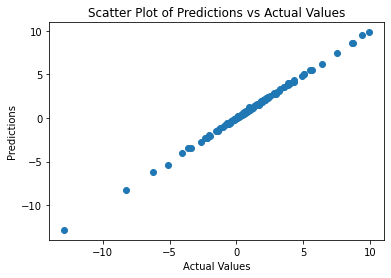

In [27]:
# We make the same plots as with INDPRO
gamma_test = df_gamma['gamma_test'].to_numpy()
gamma_pred = df_gamma['gamma_pred'].to_numpy()

plt.scatter(gamma_test, gamma_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("Scatter Plot of Predictions vs Actual Values")
plt.show()

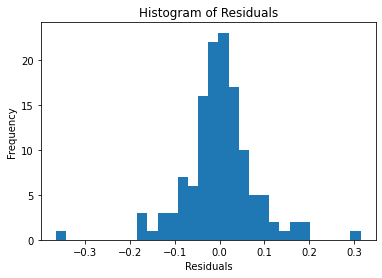

In [28]:
residus_gamma = gamma_test - gamma_pred
plt.hist(residus_gamma, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

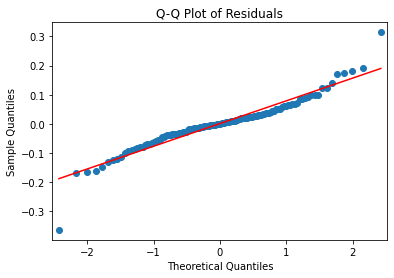

In [29]:
sm.qqplot(residus_gamma, line='r')
plt.title("Q-Q Plot of Residuals")
plt.show()